In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci, ppi_ols_pointestimate
from statsmodels.regression.linear_model import OLS
from scipy.optimize import brentq  
from sklearn.linear_model import Ridge
from tqdm import tqdm
from utils import *

In [3]:
def generate_data(p, n, theta=None, noise_std=1.0, mu = -2, sigma = 1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)
    if theta is None:
        theta = np.random.uniform(-1, 1, p)
    X = np.random.randn(n, p)
    eps = np.random.randn(n) * noise_std
    Y = X @ theta + eps

    eps_pred = np.random.randn(n) * sigma + mu
    Yhat = X @ theta + eps_pred
    # Yhat = Y + eps_pred
    return X, Y, Yhat,theta

In [5]:
ns = np.array([1000, 2000, 3000, 4000, 5000])
num_trials = 10
n_total = 100000
alpha = 0.1
coordinate = 0

In [7]:
results = []
sigmas = [0.01, 0.1, 0.5, 1.0]
mus = [0, -0.01, -0.1, -1.0, -2.0, -5.0]
# mus = [0, -2]
p = 2
theta0 = [0.5,-0.5]
noise = 0.1

for mu in mus:
    for sigma in tqdm(sigmas):
        X_total, Y_total, Yhat_total, theta = generate_data(n=n_total, p=p, theta=theta0, noise_std=noise, mu=mu, sigma=sigma)
        # Yhat_total = 0.5 * Y_total
        for n in ns:
            for j in range(num_trials):
                idx = np.random.permutation(n_total)
                _X, _X_unlabeled = X_total[idx[:n]], X_total[idx[n:]]
                _Y, _Y_unlabeled = Y_total[idx[:n]], Y_total[idx[n:]]
                _Yhat, _Yhat_unlabeled = Yhat_total[idx[:n]], Yhat_total[idx[n:]]

                ppi_ci, _ = ppi_ols_ci(_X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha, lam=1)
                tuned_ppi_ci, lamb = ppi_ols_ci(_X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha)
                classical_ci = classical_ols_ci(_X, _Y, alpha=alpha)

                # Append results
                results += [
                    pd.DataFrame(
                        [
                            {
                                "method": "PPI",
                                "n": n,
                                "lower": ppi_ci[0][coordinate],
                                "upper": ppi_ci[1][coordinate],
                                "trial": j,
                                "mu": mu,
                                "sigma": sigma,
                                "coverage": (ppi_ci[0][coordinate] <= theta[coordinate]) & (ppi_ci[1][coordinate] >= theta[coordinate]),
                                "error":(((ppi_ci[0]+ppi_ci[1])/2 - theta) ** 2).mean(),
                            }
                        ]
                    )
                ]
                results += [
                    pd.DataFrame(
                        [
                            {
                                "method": "Tuned PPI",
                                "n": n,
                                "lower": tuned_ppi_ci[0][coordinate],
                                "upper": tuned_ppi_ci[1][coordinate],
                                "trial": j,
                                "mu": mu,
                                "sigma": sigma,
                                "lambda": lamb,
                                "coverage": (tuned_ppi_ci[0][coordinate] <= theta[coordinate]) & (tuned_ppi_ci[1][coordinate] >= theta[coordinate]),
                                "error":(((tuned_ppi_ci[0]+tuned_ppi_ci[1])/2 - theta) ** 2).mean(),
                            }
                        ]
                    )
                ]


                results += [
                    pd.DataFrame(
                        [
                            {
                                "method": "Classical",
                                "n": n,
                                "lower": classical_ci[0][coordinate],
                                "upper": classical_ci[1][coordinate],
                                "trial": j,
                                "mu": mu,
                                "sigma": sigma,
                                "coverage": (classical_ci[0][coordinate] <= theta[coordinate]) & (classical_ci[1][coordinate] >= theta[coordinate]),
                                "error":(((classical_ci[0]+classical_ci[1])/2 - theta) ** 2).mean(),
                            }
                        ]
                    )
                ]
                
df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]
df.to_csv("revise_noise0.1_generatenormal_10w.csv", index=False)

100%|██████████| 4/4 [00:48<00:00, 12.22s/it]


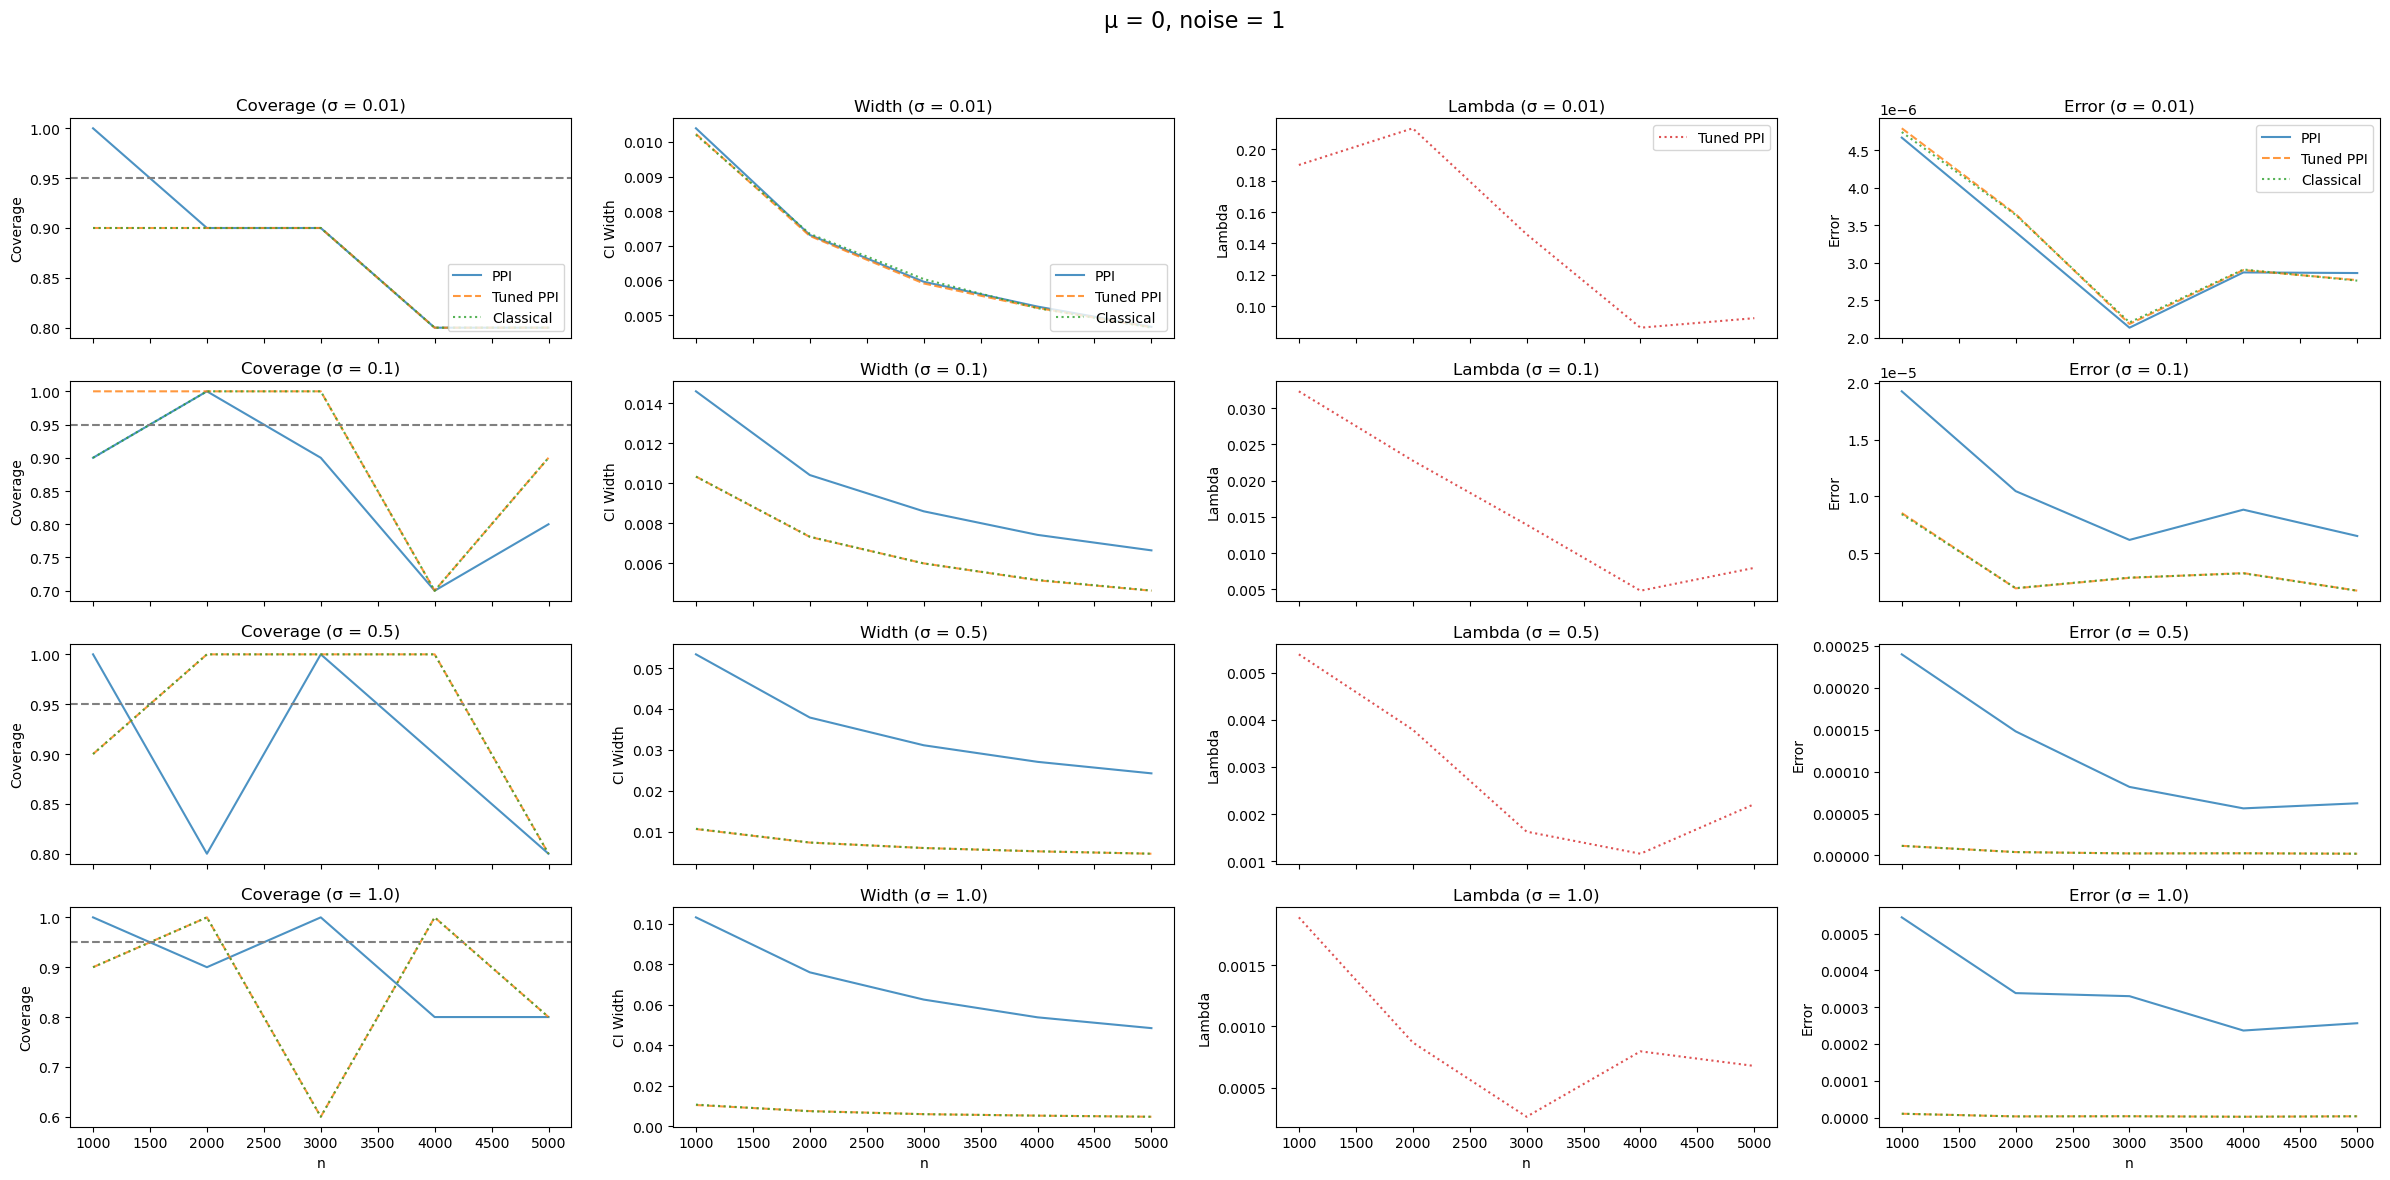

In [9]:
df = pd.read_csv("revise_noise0.1_generatenormal_10w.csv")
df_mu = df[df["mu"] == 0] 
summary = (
    df_mu.groupby(["method", "sigma", "n"])
    .agg(
        coverage=("coverage", "mean"),
        width=("width", "mean"),
        lam=("lambda", "mean"),
        error=("error", "mean") 
    )
    .reset_index()
)

linestyles = {
    "PPI": "-",
    "Tuned PPI": "--",
    "Classical": ":",
}

sigmas = [0.01, 0.1, 0.5, 1.0]

fig, axes = plt.subplots(4, 4, figsize=(24, 12), sharex=True)

for i, sigma in enumerate(sigmas):
    sub = summary[summary["sigma"] == sigma]

    # Coverage (左列)
    ax_cov = axes[i, 0]
    for method in ["PPI", "Tuned PPI", "Classical"]:
        sns.lineplot(
            data=sub[sub["method"] == method],
            x="n",
            y="coverage",
            label=method if i == 0 else None,  # Only label on top plot
            ax=ax_cov,
            linestyle=linestyles[method],
            alpha=0.8,
        )
    ax_cov.axhline(0.95, linestyle="--", color="gray")
    ax_cov.set_title(f"Coverage (σ = {sigma})")
    ax_cov.set_xlabel("n" if i == 3 else "")
    ax_cov.set_ylabel("Coverage")

    # Width (中间列)
    ax_width = axes[i, 1]
    for method in ["PPI", "Tuned PPI", "Classical"]:
        sns.lineplot(
            data=sub[sub["method"] == method],
            x="n",
            y="width",
            label=method if i == 0 else None,
            ax=ax_width,
            linestyle=linestyles[method],
            alpha=0.8,
        )
    ax_width.set_title(f"Width (σ = {sigma})")
    ax_width.set_xlabel("n" if i == 3 else "")
    ax_width.set_ylabel("CI Width")

    # Lambda (右列，仅 Tuned PPI)
    ax_lambda = axes[i, 2]
    sns.lineplot(
            data=sub[sub["method"] == "Tuned PPI"],
            x="n",
            y="lam",
            label="Tuned PPI" if i == 0 else None,
            ax=ax_lambda,
            color="tab:red",
            linestyle=linestyles[method],
            alpha=0.8,
        )
    ax_lambda.set_title(f"Lambda (σ = {sigma})")
    ax_lambda.set_xlabel("n" if i == 3 else "")
    ax_lambda.set_ylabel("Lambda")

    ax_error = axes[i, 3]
    for method in ["PPI", "Tuned PPI", "Classical"]:
        sns.lineplot(
            data=sub[sub["method"] == method],
            x="n",
            y="error",
            label=method if i == 0 else None,
            ax=ax_error,
            linestyle=linestyles[method],
            alpha=0.8,
        )
    ax_error.set_title(f"Error (σ = {sigma})")
    ax_error.set_xlabel("n" if i == 3 else "")
    ax_error.set_ylabel("Error")

# 可选，调整 legend
if axes[0, 0].get_legend():
    axes[0, 0].legend(loc="lower right")
if axes[0, 1].get_legend():
    axes[0, 1].legend(loc="lower right")
if axes[0, 2].get_legend():
    axes[0, 2].legend(loc="upper right")


plt.suptitle("μ = 0, noise = 1", fontsize=16)
#plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()
